In [70]:
# Based on Keras lstm_text_generation.py example.

'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 600901


In [3]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 59


In [39]:
# Let's take a look.
print(''.join(chars))
print(char_indices['a'])
print(indices_char[27])


 !"'(),-.0123456789:;=?[]_abcdefghijklmnopqrstuvwxyz������
27
a


Looks like there are some non-standard chars in the text... 

In [4]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 200287


In [40]:
# Now we have chunks of 40 characters from the text, jumping by 3 chars each time. 
# next_chars contains the character that follows after each string of text...
for i in range(10): 
    print(repr(sentences[i]), next_chars[i])

'preface\n\n\nsupposing that truth is a woma' n
'face\n\n\nsupposing that truth is a woman--' w
'e\n\n\nsupposing that truth is a woman--wha' t
'\nsupposing that truth is a woman--what t' h
'pposing that truth is a woman--what then' ?
'sing that truth is a woman--what then? i' s
'g that truth is a woman--what then? is t' h
'hat truth is a woman--what then? is ther' e
' truth is a woman--what then? is there n' o
'uth is a woman--what then? is there not ' g


In [5]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


Let's understand what the code above does:

- our model will take a string of text and predict the likelihood of the next character
- the inputs for training will be strings of 40 chars, and the label we'll try to get the network to predict is the 
  next character.
- characters are one-hot encoded vectors, so of length 59.
- So, `X[i,:,:]` is the i-th sentence in our training set, ...
- ...and `X[i,t,:]` is the one-hot vector for the t-th letter in the sentence.

Let's take a look

In [45]:
print(X.shape)
print("First letter of first sentence: ", X[0][0].astype(int))
# Which character is it? Based on text above, should be 'p'
idx = np.argmax(X[0][0])
print("Decoding the one-hotness, first char:", indices_char[idx])

(200287, 40, 59)
First letter of first sentence:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Decoding the one-hotness, first char: p


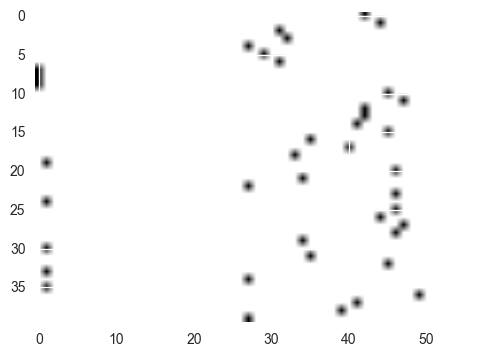

In [60]:
# just for fun, let's visualize our inputs...
plt.imshow(X[0])

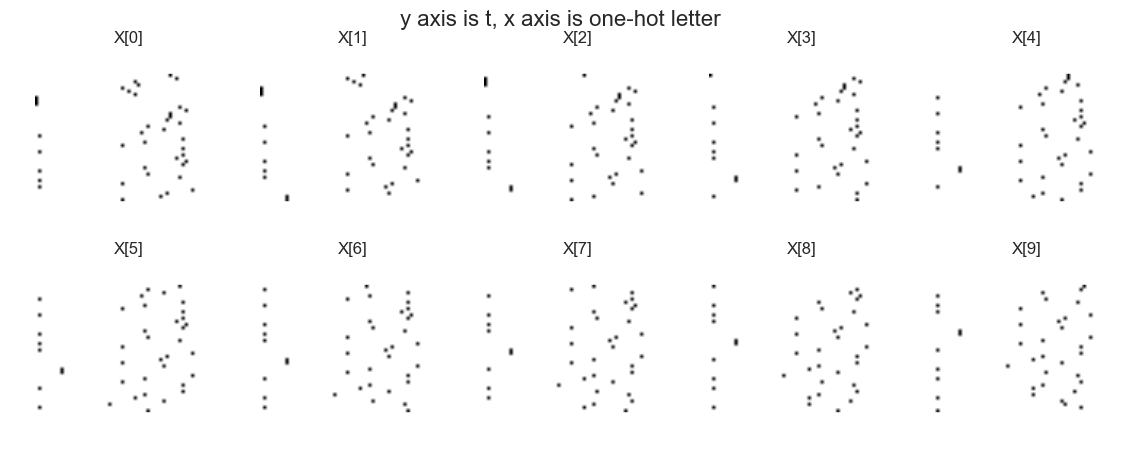

In [74]:
K = 10
fig, axs = plt.subplots(2,5,figsize=(14,5),sharex=True, sharey=True)
axs = axs.flatten()
for i in range(K):
    axs[i].imshow(X[i])
    axs[i].set_title("X[{}]".format(i))
    axs[i].axis('off')
fig.suptitle('y axis is t, x axis is one-hot letter', fontsize=16)

# Build the model

In [6]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
# We'll have 128 hidden LSTM units -- each learning a different mapping from history + current sentence. 
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
# and then map to 59 outputs
model.add(Dense(len(chars)))
# as usual, normalized into a valid distribution using softmax 
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
# Same as our image classification tasks, we use cross-entropy as the loss measure.
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [46]:
# Each input we'll feed to the model is a sequence of maxlen (aka 40) characters,
# each one-hot-encoded out of the 59 chars.
print(model.input_shape)

(None, 40, 59)


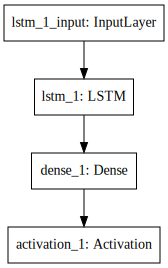

In [8]:
from display import visualize_keras_model
visualize_keras_model(model)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               96256     
_________________________________________________________________
dense_1 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 103,867.0
Trainable params: 103,867.0
Non-trainable params: 0.0
_________________________________________________________________


where did 96256 come from in the first layer? Is it like our dense networks, mapping each element of the input with a separate weight for each unit? Let's see...

In [64]:
128 * 40 * 59

302080

Hmm... 302080 > 96256. So clearly that's not it. Aha. Now we remember that the idea behind RNNs in general is to reuse weights, just in a different way than convolutions -- for a given sequence element we'll use the same weights. So I guess we don't need the factor of 40...

In [65]:
128 * 59

7552

Ok, now we have a number smaller than 96256, but it still doesn't match. Now we have to recall that an LSTM unit is complicated -- it needs to learn how to weigh the input, whether to remember or forget, whether to propagate the output, etc. So there'll be more than one parameter per unit:

In [63]:
96256 / (128 * 59)

12

...and in fact, there are twelve parameters to learn per unit. Let's double check our dense layer count.

In [69]:
128 * 59 + 59 # remember to add the biases

7611

In [26]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

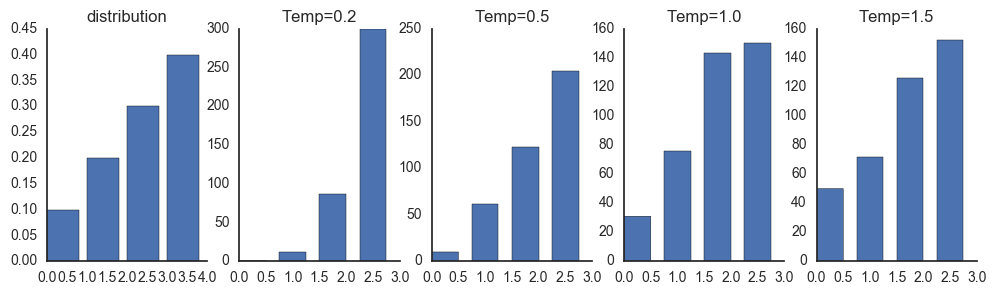

In [94]:
# Let's look at the effect of temperature parameter
def plot_samples(dist, temp, ax=None):
    K = 400
    samples = [sample(dist, temp) for i in range(K)]
    if not ax:
        fig, ax = plt.subplots(figsize=(3,2))
    ax.set_title("Temp={}".format(temp))
    ax.hist(samples, bins=4, width=0.5)
    sns.despine(ax.get_figure())
    
    
dist = [0.1, 0.2, 0.3, 0.4]
temps = [0.2, 0.5, 1.0, 1.5]
fig, axs = plt.subplots(1,5, figsize=(12, 3))
axs[0].bar(range(4), dist)
axs[0].set_title("distribution")
for i, temp in enumerate(temps):
    plot_samples(dist, temp, ax=axs[i+1])

So the lower the temperature, the more it insists of choosing the highest probability option. With higher temp, it explores more.

In [ ]:
# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
200287/200287 [==============================] - 264s - loss: 1.9594   

----- diversity: 0.2
----- Generating with seed: "s the imperative duty of any science
tha"
s the imperative duty of any science
that the self--the self--the self--the self--the self--the self--the superstand the self--we as a morality and the self--the self--the self--the self--the interesterstance of the self--the superscient of the self--morality of the man the self--the supersceptions and the interestance of the self--the enting the least of the entaring and also the sight to the self--the self--the self--proble to the sel

----- diversity: 0.5
----- Generating with seed: "s the imperative duty of any science
tha"
s the imperative duty of any science
that all the self--such of the beances, and antartent of a such
all the expersoring, of the self--problems who proble such a fearing and the have and the really
something to the langually in